# Imports

In [36]:
import numpy as np
import pandas as pd
from scipy import ndimage
import seaborn as sns
from joblib import delayed, Parallel
import matplotlib.pyplot as plt
from typing import Tuple

# Utils

In [2]:
def analyze_clusters(microplate: np.ndarray, min_size: int = 2) -> Tuple:
    """
    Analyze cell clusters on a microplate 
    
    Parameters
    ----------
    microplate : np.ndarray
        a 2D binary matrix representing a microplate assay
    
    Returns
    -------
    tuple
        (number of positive cells, number of clusters, size of largest cluster)
    """
    matrix = np.nan_to_num(microplate, 0)
    structure = ndimage.generate_binary_structure(2, 1)
    
    clusters, num_clusters = ndimage.label(matrix, structure)
    cluster_sizes = ndimage.sum(matrix, clusters, range(0, num_clusters + 1))
    
    mask = (cluster_sizes >= min_size)[clusters]
    clusters = clusters[mask]
    
    unique_labels, label_counts = np.unique(clusters, return_counts=True)
    max_cluster_size = label_counts.max() if label_counts.size > 0 else 0
    
    return int(np.sum(matrix)), len(unique_labels), max_cluster_size

# Settings

In [3]:
results = {}

In [17]:
microplates = 10000    
shape = (8, 12)        
prevalence = 0.18
controls = 6
controls_position = 'top-left'
seed = 123
processes = 1

# Simulate

In [18]:
np.random.seed(seed)

In [19]:
num_samples = microplates * (shape[0] * shape[1] - controls)
samples = np.random.binomial(1, prevalence, size=num_samples)
samples.shape

(900000,)

In [20]:
vectors = np.split(samples, microplates)
len(vectors)

10000

In [21]:
if controls_position == 'top-left':
    padding = (controls, 0)
elif controls_position == 'bottom_right':
    padding = (0, controls)
else:
    raise ValueError

In [22]:
def _analyze(vector, padding, shape):
    matrix = np.pad(vector, padding, constant_values=0)
    matrix = np.reshape(matrix, shape)
    return analyze_clusters(matrix)

In [23]:
rv = Parallel(n_jobs=2, verbose=10)(delayed(_analyze)(vector, padding, shape) for vector in vectors)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Batch computation too fast (0.0237s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Batch computation too fast (0.0249s.) Setting batch_size=4.
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Batch computation too fast (0.0190s.) Setting batch_size=8.
[Parallel(n_jobs=2)]: Batch computation too fast (0.0175s.) Setting batch_size=16.
[Parallel(n_jobs=2)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Batch computation too fast (0.0788s.) Setting batch_size=32.
[Parallel(n_jobs=2)]: Done 156 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Batch computation too fast (0.0308s.) Setting batch_size=64.
[Parallel(n_jobs=2)]: Batch computation too fast (0.0541s.) Setting batch_size=128.
[Parallel(n_jobs=2)]: Done 508 tasks     

In [24]:
rv = np.array(rv)
rv.shape

(10000, 3)

In [25]:
results[prevalence] = rv

# Analyze

## Num positive cells

In [54]:
col = 0

In [55]:
for key, data in results.items():
    print(key, np.median(data[:, col]), np.mean(data[:, col]), np.min(data[:, col]), np.max(data[:, col]), 
          np.percentile(data[:, col], 95))

0.16 14.0 14.3732 3 29 20.0
0.18 16.0 16.1623 4 30 22.0


/Users/andreasfragner/Documents/personal/dev/qa-dna-batch-testing/.venv/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/andreasfragner/Documents/personal/dev/qa-dna-batch-testing/.venv/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


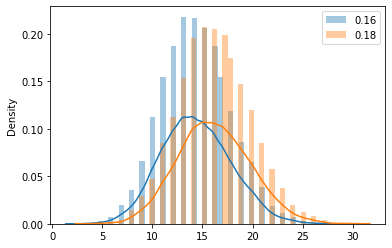

In [60]:
for key, data in results.items():
    sns.distplot(data[:, col], label=key)
    plt.legend()

## Num clusters

In [61]:
col = 1

In [62]:
for key, data in results.items():
    print(key, np.median(data[:, col]), np.mean(data[:, col]), np.min(data[:, col]), np.max(data[:, col]), 
          np.percentile(data[:, col], 95))

0.16 2.0 2.5643 0 9 5.0
0.18 3.0 3.03 0 9 5.0


/Users/andreasfragner/Documents/personal/dev/qa-dna-batch-testing/.venv/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/andreasfragner/Documents/personal/dev/qa-dna-batch-testing/.venv/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


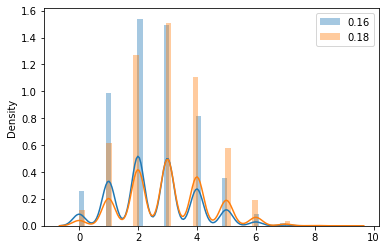

In [64]:
for key, data in results.items():
    sns.distplot(data[:, col], label=key)
    plt.legend()

## Size of largest cluster

In [65]:
col = 2

In [66]:
for key, data in results.items():
    print(key, np.median(data[:, col]), np.mean(data[:, col]), np.min(data[:, col]), np.max(data[:, col]), 
          np.percentile(data[:, col], 95))

0.16 3.0 3.0724 0 13 6.0
0.18 3.0 3.4802 0 13 6.0


/Users/andreasfragner/Documents/personal/dev/qa-dna-batch-testing/.venv/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/andreasfragner/Documents/personal/dev/qa-dna-batch-testing/.venv/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


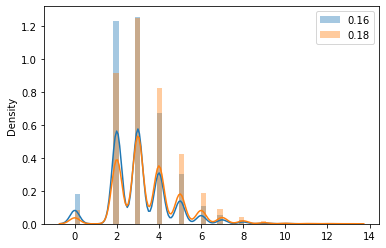

In [67]:
for key, data in results.items():
    sns.distplot(data[:, col], label=key)
    plt.legend()